In [ ]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from astropy.cosmology import FlatwCDM
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from iminuit import Minuit
import pandas as pd
import time
from scipy.interpolate import interp1d
import math
import testt.libraryAP as libraryAP


#importation des donnés
df = pd.read_csv("fsig8ml.dat", sep=";")

z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())


In [4]:

minimizer = Minuit(libraryAP.Chi2_AP, omega_m0=0.3, sigma8_0=0.7,w=-1,H0 = 73.4)
minimizer.limits["omega_m0"] = (0,1)
minimizer.limits["sigma8_0"] = (0,1)  # Valeurs plus physiques
minimizer.fixed["w"] = True
minimizer.fixed["H0"] =  True
minimizer.errordef = 1.0  # Pour chi2
minimizer.strategy = 2    # Plus précis
result = minimizer.migrad()
print(result)

# Statistiques du fit
chi2_val = minimizer.fval
ndof = len(fsig8) - len(minimizer.parameters)
chi2_reduit = chi2_val / ndof

print(f"\nRésultats du fit :")
print(f"Chi2 = {chi2_val:.2f}")
print(f"Nombre de degrés de liberté = {ndof}")
print(f"Chi2 réduit = {chi2_reduit:.2f}")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega_m0']:.3f} ± {minimizer.errors['omega_m0']:.3f}")
print(f"σ8,0 = {minimizer.values['sigma8_0']:.3f} ± {minimizer.errors['sigma8_0']:.3f}")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.73                      │              Nfcn = 38               │
│ EDM = 6.02e-07 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_8444\1005322261.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


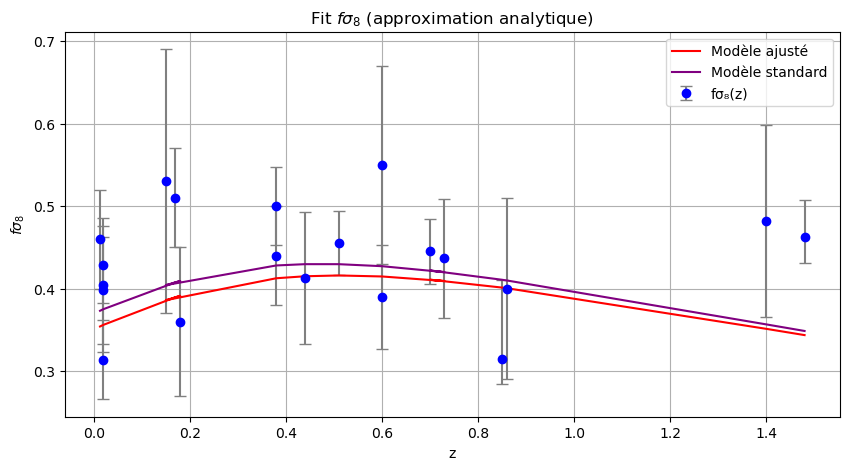

In [6]:
omega_m0_fit = minimizer.values["omega_m0"]
sigma8_0_fit = minimizer.values["sigma8_0"]
w_fit = minimizer.values["w"]
om_ms = 0.334
S8_ms = 0.81
sig8_ms = S8_ms*(0.3/om_ms)**(0.5)

gamma_fit = libraryAP.gamma(omega_m0_fit,w_fit,z_data)
modele = libraryAP.omega_mGamma(z_data, gamma_fit, omega_m0_fit,w_fit) * np.array(libraryAP.sigma8(sigma8_0_fit, omega_m0_fit, z_data,w_fit))
gamma_modele_standard = libraryAP.gamma(om_ms, -1,z_data)
modele_standard = libraryAP.omega_mGamma(z_data, gamma_modele_standard,om_ms,-1) * np.array(libraryAP.sigma8(sig8_ms,om_ms, z_data,-1))

# --- Plot 1 : Fit et données ---
plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele, 'r-', label='Modèle ajusté')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)

In [18]:
H0 = 73.4

def compute_grid_Chi2(omega_vals, sigma_vals, w_vals, om_best, sig8_best, w_best):
    # Ωm0 vs σ8 (w fixé)
    OM, Sig8 = np.meshgrid(omega_vals, sigma_vals, indexing='ij')
    chi2_grid_om_sig8 = np.vectorize(lambda om, sig8: library.Chi2_AP(om, sig8, w_best,H0))(OM, Sig8)

    # Ωm0 vs w (σ8 fixé)
    OM, W = np.meshgrid(omega_vals, w_vals, indexing='ij')
    chi2_grid_om_w = np.vectorize(lambda om, w: library.Chi2_AP(om, sig8_best,w,H0))(OM, W)

    # σ8 vs w (Ωm0 fixé)
    Sig8, W = np.meshgrid(sigma_vals, w_vals, indexing='ij')
    chi2_grid_sig8_w = np.vectorize(lambda sig8, w: library.Chi2_AP(om_best, sig8, w,H0))(Sig8, W)

    return chi2_grid_om_sig8, chi2_grid_om_w, chi2_grid_sig8_w

def compute_grid_Chi2_ms(omega_vals, sigma_vals, w_vals, om_best, sig8_best, w_best,H0):
    # Ωm0 vs σ8 (w fixé)
    OM, Sig8 = np.meshgrid(omega_vals, sigma_vals, indexing='ij')
    chi2_grid_om_sig8 = np.vectorize(lambda om, sig8: library.Chi2_AP(om, sig8, w_best,H0))(OM, Sig8)
    
    return chi2_grid_om_sig8


In [19]:
from tqdm import tqdm  # pour la barre de progression (facultatif)
N = 100
omega_m0_vals = np.linspace(0,0.6,N)
sigma8_0_vals = np.linspace(0.5,1.9,N)
w_vals = np.linspace(-1.75,0.5,N)

# On va projeter sur chaque plan 2D en fixant le troisième paramètre à sa valeur best-fit
chi2_grid_om_si8 = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))
chi2_grid_om_w = np.zeros((len(omega_m0_vals), len(w_vals)))
chi2_grid_si8_w = np.zeros((len(sigma8_0_vals), len(w_vals)))

# Best-fit
om_best = minimizer.values['omega_m0']
sig8_best = minimizer.values['sigma8_0']
w_best = minimizer.values['w']

# --- Calcul des grilles ---
print("Début du calcul des grilles χ² vectorisées...")

start = time.time()
chi2_grid_om_sig8, chi2_grid_om_w, chi2_grid_sig8_w = library.compute_grid_Chi2(omega_m0_vals, sigma8_0_vals, w_vals, om_best, sig8_best, w_best)
end = time.time()

print(f"Calcul terminé en {end - start:.2f} secondes.")

# --- Sauvegarde dans un fichier compressé ---
np.savez_compressed("chi2_grids2.npz",omega_m0_vals=omega_m0_vals,sigma8_0_vals=sigma8_0_vals,w_vals=w_vals,chi2_grid_om_sig8=chi2_grid_om_sig8,chi2_grid_om_w=chi2_grid_om_w,chi2_grid_sig8_w=chi2_grid_sig8_w)

print("Grilles sauvegardées dans 'chi2_grids.npz'.")

Début du calcul des grilles χ² vectorisées...
Calcul terminé en 16.45 secondes.
Grilles sauvegardées dans 'chi2_grids.npz'.


In [20]:
# On va projeter sur chaque plan 2D en fixant le troisième paramètre à sa valeur best-fit
chi2_grid_om_si8_ms = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))
chi2_grid_om_w_ms = np.zeros((len(omega_m0_vals), len(w_vals)))
chi2_grid_si8_w_ms = np.zeros((len(sigma8_0_vals), len(w_vals)))

# Paramètres du modèle standard
om_ms = 0.334
sig8_ms = 0.81 * (0.3 / om_ms) ** (0.5)
w_ms = -1
# --- Calcul des grilles modèle standard ---
print("Début du calcul vectorisé des grilles χ² pour le modèle standard...")

start = time.time()
chi2_grid_om_sig8_ms = library.compute_grid_Chi2_ms(omega_m0_vals, sigma8_0_vals, w_vals, om_ms, sig8_ms, w_ms)
end = time.time()

print(f"Grilles χ² du modèle standard calculées en {end:.2f} secondes.")

# --- Sauvegarde ---
np.savez_compressed(
    "chi2_grids_model_std.npz",
    chi2_grid_om_sig8_ms=chi2_grid_om_sig8_ms,
   
)
print("Grilles χ² (modèle standard) sauvegardées dans 'chi2_grids_model_std.npz'.")

Début du calcul vectorisé des grilles χ² pour le modèle standard...
Grilles χ² du modèle standard calculées en 1750165630.33 secondes.
Grilles χ² (modèle standard) sauvegardées dans 'chi2_grids_model_std.npz'.


Affichage du triplot...


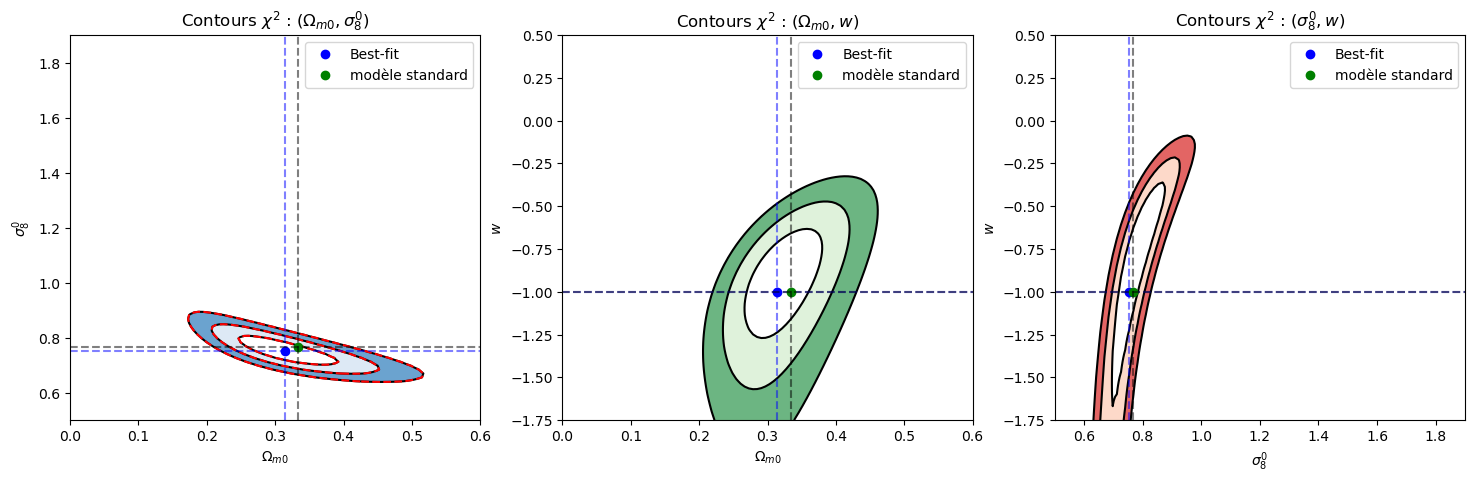

In [21]:
# --- Niveaux pour les contours (Δχ² pour 2 paramètres libres) ---
levels = [minimizer.fval + d for d in [2.30, 6.18, 11.83]]  # 1σ, 2σ, 3σ

# --- Triplot façon FlatΛCDM ---
print("Affichage du triplot...")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Ωm0 vs sig8 (w fixé)
cf1 = axs[0].contourf(omega_m0_vals, sigma8_0_vals, chi2_grid_om_sig8.T, levels=levels, cmap='Blues', alpha=0.7)
c1 = axs[0].contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_sig8.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)
c1_ms = axs[0].contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_sig8_ms.T, levels=levels, colors='r', linestyles='dashed')
axs[0].plot(om_best, sig8_best, 'bo', label='Best-fit')
axs[0].axvline(om_best, color='blue', linestyle='--', alpha=0.5)
axs[0].axhline(sig8_best, color='blue', linestyle='--', alpha=0.5)
axs[0].plot(om_ms, sig8_ms, 'go', label='modèle standard')
axs[0].axvline(om_ms, color='black', linestyle='--', alpha=0.5)
axs[0].axhline(sig8_ms, color='black', linestyle='--', alpha=0.5)
axs[0].set_xlabel(r'$\Omega_{m0}$')
axs[0].set_ylabel(r'$\sigma_8^0$')
axs[0].set_title(r'Contours $\chi^2$ : $(\Omega_{m0}, \sigma_8^0)$')
axs[0].legend()
#fig.colorbar(cf1, ax=axs[0], label=r'$\chi^2$')

# Ωm0 vs w (sig8 fixé)
cf2 = axs[1].contourf(omega_m0_vals, w_vals, chi2_grid_om_w.T, levels=levels, cmap='Greens', alpha=0.7)
c2 = axs[1].contour(omega_m0_vals, w_vals, chi2_grid_om_w.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)

axs[1].plot(om_best, w_best, 'bo', label='Best-fit')
axs[1].axvline(om_best, color='blue', linestyle='--', alpha=0.5)
axs[1].axhline(w_best, color='blue', linestyle='--', alpha=0.5)
axs[1].plot(om_ms, w_ms, 'go', label='modèle standard')
axs[1].axvline(om_ms, color='black', linestyle='--', alpha=0.5)
axs[1].axhline(w_ms, color='black', linestyle='--', alpha=0.5)
axs[1].set_xlabel(r'$\Omega_{m0}$')
axs[1].set_ylabel(r'$w$')
axs[1].set_title(r'Contours $\chi^2$ : $(\Omega_{m0}, w)$')
axs[1].legend()
#fig.colorbar(cf2, ax=axs[1], label=r'$\chi^2$')

# sig8 vs w (Ωm0 fixé)
cf3 = axs[2].contourf(sigma8_0_vals, w_vals, chi2_grid_sig8_w.T, levels=levels, cmap='Reds', alpha=0.7)
c3 = axs[2].contour(sigma8_0_vals, w_vals, chi2_grid_sig8_w.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)

axs[2].plot(sig8_best, w_best, 'bo', label='Best-fit')
axs[2].axvline(sig8_best, color='blue', linestyle='--', alpha=0.5)
axs[2].axhline(w_best, color='blue', linestyle='--', alpha=0.5)
axs[2].plot(sig8_ms, w_ms, 'go', label='modèle standard')
axs[2].axvline(sig8_ms, color='black', linestyle='--', alpha=0.5)
axs[2].axhline(w_ms, color='black', linestyle='--', alpha=0.5)
axs[2].set_xlabel(r'$\sigma_8^0$')
axs[2].set_ylabel(r'$w$')
axs[2].set_title(r'Contours $\chi^2$ : $(\sigma_8^0, w)$')
axs[2].legend()